# Nuclear data uncertainties and covariances

Please indicate your name below, since you will need to submit this notebook completed latest the day after the datalab.

Don't forget to save your progress during the datalab to avoid any loss due to crashes.

In [1]:
name=''

Nuclear data, such as the cross section values are based on measurements and theoretical models, therefore they do have uncertainties from systematic and random errors. These uncertainties then propagate into the neutronics computations where the data is being used, therefore it is essential to have an understanding of these uncertainties. 

In this notebook we are not going to do too much programming, because the topic is rather complicated, and it is difficult to even parse the uncertainty data from the ENDF files by ourselves. The study of nuclear data uncertainties and covariances is still a rather young field, being heavily under development: classic textbooks (such as [Nuclear Reactor Analysis from Duderstadt and Hamilton](https://deepblue.lib.umich.edu/bitstream/handle/2027.42/89079/1976_Nuclear_Reactor_Analysis.pdf)) do not even mention it. Instead, we will review the basics, learn how to access covariance information, and how it can used in subsequent calculations. At the end of this notebook, you have gained a working understanding of the topic, and you will be able to read the related literature to dig further upon interest. One can find the [NJOY16 manual](https://raw.githubusercontent.com/njoy/NJOY2016-manual/master/njoy16.pdf) (Chapter 10.) and the [ORNL/TM-2006/147](https://technicalreports.ornl.gov/cppr/y2001/rpt/125304.pdf) report particularly helpful. In fact, our review is also largely based on these.

One can define a joint distribution so that

$$P(\sigma_1,\sigma_2,...)d\sigma_1d\sigma_2$$

gives the probability that the true value of $\sigma_1$ and $\sigma_2$ etc. lies within the range $(\sigma_1,\sigma_1+d\sigma_1)$ and $(\sigma_2,\sigma_2+d\sigma_2)$. Up to now, in this learning module we have only looked at the first moment of this distribution, that is the expected values. In the newer ENDF files however, the second moments of the distribution is also included for several nuclides, which describe the uncertainty and correlations. This is often referred to as "nuclear data covariances". 

Further we can recall from statistics that the covariance of two random variables measures to which extent are the two variables affected by the same sources of errors:

$$\text{cov}(\sigma_i,\sigma_j)\equiv\mathbb{E}\big[(\sigma_i-\mathbb{E}(\sigma_i))(\sigma_j-\mathbb{E}(\sigma_j))\big]$$

The uncertainty or standard deviation can be defined as

$$\Delta\sigma_i\equiv\sqrt{\text{var}(\sigma_i)}=\sqrt{\text{cov}(\sigma_i,\sigma_i)}$$

and with that the correlation can be defined as

$$\text{corr}(\sigma_i,\sigma_j)\equiv\frac{\text{cov}(\sigma_i,\sigma_j)}{\Delta\sigma_i\Delta\sigma_j}$$

Roughly put, the nuclear data covariance measures how correlated given values are to other values, for example the cross section measured at one energy to the cross section measured at other energies (for example due to originiating from the same underlying measurement). 

### Covariance data in ENDF

The raw ENDF files may contain the covariance information in MF31 (for nubar), MF32 (for resonance parameters), MF33 (for cross sections), etc. The general rule is that in case the data is given in File N, the covariance data is given in File N+30 (eg. cross sections can be found in MF3, hence covariances are given in MF33). These files are further organized into subsections and subsubsections (the interested reader is referred to the above mentioned literature). In our following discussions we will limit ourselves to the covariance of cross sections, and will look only at the covariances for the capture cross section of U-238 (however one can access the covariance between different reactions as well). 

You may recall that the cross sections were given in MF3 for a small number of energy points, and one could reconstruct a point-wise cross section with interpolation laws. Covariance data is similarly given only for a grid of energies, and can be used later for computing the covariance for other energies. However most often not this raw data is illustrated in publications but a group-wise representation, which is, as we will see later, is created by processing the raw data with tool such as NJOY.

As said earlier, we are not going to deal with the raw data, and make illustrations from scratch, because that would have little pedagogical advantage for too much work.

Instead we highlight that the [Nuclear Data Services of IAEA](https://www-nds.iaea.org/exfor/endf.htm), provides tools to visualize the covariance data. One can visit directly the [Web-ZVView page](https://www-nds.iaea.org/exfor/myplot.htm), or select the COV/SIG quantity in the standard requests, such as below for the capture cross section on U-238:

![](figures/NDS_cov.png) 

Then one can select the "MF33-Plot" option for the preferred nuclear data library

![](figures/NDS_covMF33.png) 

in order to obtain a visualization of the covariances/correlations:

![](figures/NDS_covMF33plot.png) 

Observe that the correlation map is different for the various libraries (since different experimental setups and analysis tools were used to create the library).

In case you would like to create your own plot, you can download the plotted data (see right side of the figure above), for example in JSON format. The file `data/U238cov.json` was obtained in this way. One can read the content into a numpy matrix with the code below and then create a similar plot as above for example with `plt.contourf`.

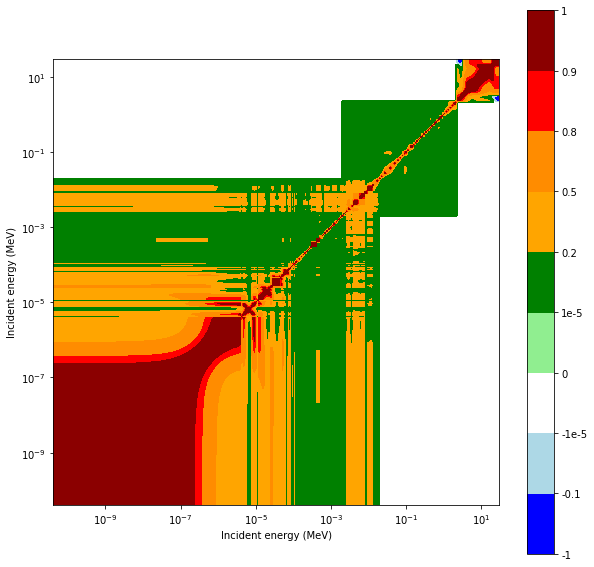

In [2]:
import json
import numpy as np
import matplotlib.pyplot as plt

#Load json file
file='data/U238cov.json'
with  open (file) as json_file:
    covJSON = json.load(json_file)

#Create a mesh grid for the energies
X=covJSON['funcs'][0]['xArray']
Y=covJSON['funcs'][0]['yArray']
Xn, Yn = np.meshgrid(X, Y)

#Read the matrix values from the JSON format
data=np.zeros((len(X),len(Y)))
for i,row in enumerate(covJSON['funcs'][0]['zArray2']):
    for j,col in enumerate(row):
        data[i,j]=col

#Create a similar plot as NDS-IAEA
fig, ax = plt.subplots(figsize=(10,10))
im=ax.contourf(Xn,Yn,data/100,levels=[-1,-0.1,-1e-5,0,1e-5,0.2,0.5,0.8,0.9,1], 
               colors=['blue','lightblue','white','lightgreen','green','orange','darkorange','red','darkred'])
ax.autoscale(False)
ax.set_aspect('equal')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('Incident energy (MeV)')
ax.set_ylabel('Incident energy (MeV)')
#Redefine colorbar ticks, because -1e-5 and 1e-5 would render also as '0.0' by default
cbar=fig.colorbar(im,ax=ax,orientation='vertical',ticks=[-1,-0.1,-1e-5,0,1e-5,0.2,0.5,0.8,0.9,1])
cbar.ax.set_yticklabels(['-1','-0.1','-1e-5','0','1e-5','0.2','0.5','0.8','0.9','1'])  
plt.show()

From these figures the most obvious thing to notice is that in the diagonal we observe 100% correlation, which is expected since the cross section value at a given energy is correlated to itself. But we can also observe that the variability of the probability of interaction at a certain energy is related to the probability of interaction at other energies since the same measuring equipment was used when determining the probabilities. There is strong correlation between cross sections of adjacent energy ranges. Also, we can observe long-range correlations between cross sections over large energy ranges at low and high energies. In the resonance region we can observe rapid changes in the correlation.

### Why use such covariance data?

As mentioned earlier, it is essential to characterize how nuclear data uncertainties propagate into the results of neutronics calculations. The most common method is to sample a large amount of perturbed nuclear data files and perform the same calculation with the perturbed nuclear data in order to quantify the influence of the nuclear data uncertainties in the neutronics results. It is clear however, that due to the correlations of the cross section values, during the sampling of perturbed nuclear data one needs to take into the covariance information also besides the uncertainty.

[SANDY](https://luca-fiorito-11.github.io/sandy-docs/index.html) is an open source python package which can be used for this purpose. Besides perturbing cross sections it is also able to draw random samples for angular and energy distributions and fission neutron multiplicities. In this datalab we will not use SANDY, but we strongly recommend the interested reader to install and try the code, and evaluate the influence of nuclear data uncertainties for example with a simple openMC simulation. The usage of the code is rather straight-foward. The command

`sandy  <tape>  --samples 1000`

creates 1000 perturbed copies of the nuclear data provided on `<tape>`. However the data is required to be supplied in a pointwise-ENDF (PENDF) format. (We will learn more about this format in the next datalabs).

### Multi-group covariance data

As mentioned earlier, typically the covariance data is not used and visualized in its raw format given in the ENDF. It is processed into group-wise data with tools like NJOY. In many publications, and presentations one finds similar illustrations of the covariance data, most often created with NJOY. Unfortunately, it is most often not stated how the figures were obtained, which can be frustrating to the newcomers, here we wanted to include an example from NJOY, although we will learn about using NJOY only in the next datalabs.

After reconstructing the point-wise format from the raw ENDF file, one can use the ERRORR module by specifying the group structure and the weighting spectrum. Then, the correlation matrix can be visualized as below. The top figure shows the group-wise cross section of capture reaction on U-238, the left figure gives the relative uncertainties in the cross sections, and the middle figure shows the correlation matrix. Here we have used the LANL-187 group structure, and a generic Maxwellian+1/E+Fission+Fusion weighting spectrum. Further correlation matrices can be found at [the LANL's T2 site](https://t2.lanl.gov/nis/data/endf/covVII.1/u/238cov33.pdf) for a 33-group structure. We can observe similar structure as when visualizing the raw covariance data, since the same ENDF file was used.

In [3]:
from IPython.display import IFrame
IFrame("figures/NJOYERRORR_U238.pdf", width=800, height=600)

#### NJOY input

Below you can find the NJOY input to obtain the figure. The input is well-commented, nevertheless here we do not go into more detail, we just refer to the next datalab which exlplains the syntax of NJOY. It is important to mention however that the "tape20" input ENDF file was the same what you can found in `data/U238.endf`, and which we used in the first datalab to review the features of ENDF files.


```
    moder
    20 -21  
    reconr
    -21 -22                         /reconstruct tape -21 to tape -22
    'pendf tape from U238 n,g'      /tlabel
    9237                            /MAT
    0.001                           /err
    0                               /terminate reconr
    broadr
    -21 -22 -23                     /input endf, input pendf (from reconr), output pendf
    9237 1                          /MAT, number of temperatures
    0.001                           /err
    0.                              /final temperature in K
    0                               /terminate broadr    
    moder
    -23 24                          /get an ascii
    errorr
    20 24 0 33                      /ENDF tape, PENDF tape, GENDF tape, Output tape
    9237 10 6 1 1                   /MAT, ign=10 (LANL-187), iwt=6 (maxwell+1/e+fusion/fission), print, rel.cov.
    0 0.                            /printing and temperature
    0 33                            /printing and cov. MF
    covr
    33 0 34                         /input tape, output tape, viewr output 
    1                               /color option
    /
    /
    9237 102                        /MAT, MT
    viewr
    34 35                           /image on tape 35, convert with eg. Ghostscript: ps2pdf tape35 file.pdf
    stop
```

the input can be run as 

`njoy21 -i file.inp`

and the figure will be created as a PostScript on 'tape35', which needs to be converted for example to pdf.